# OpenMeteo — Evaluación y Forecast del Modelo Híbrido (SARIMA + XGBoost)

<a id="1"></a>

## Introducción

    Este notebook tiene dos objetivos principales:

    1. Evaluar el rendimiento del modelo híbrido (SARIMA + XGBoost) sobre datos históricos.
    2. Generar y visualizar predicciones futuras para una ciudad concreta.

    El modelo híbrido está definido como:

    > **predicción_híbrida = predicción_SARIMA + residuo_predicho_XGB**

    Donde:
    - SARIMA modela la estacionalidad anual y la tendencia.
    - XGBoost aprende el residuo (real - sarima) usando features avanzadas.


# Índice
1. [Introducción](#1)
2. [Configuración inicial](#2)
3. [Importación de librerías](#3)
4. [Selección de modo y ciudad](#4)
5. [Carga y exploración de datos](#5)
6. [Análisis exploratorio](#6)
    - 6.1 Temperatura mensual por año
    - 6.2 Distribución por estación
    - 6.3 Matriz de correlación
7. [Carga de modelos SARIMA y XGBoost](#7)
8. [Evaluación 80/20 del modelo híbrido](#8)
9. [Visualización del split temporal](#9)
10. [Zoom ±1 mes del corte](#10)
11. [Comparación Real vs SARIMA vs Híbrido](#11)
12. [Distribución del error](#12)
13. [Backtesting 1-step-ahead](#13)
14. [Último mes del backtesting](#14)
15. [Forecast futuro](#15)
16. [Importancia de features](#16)
17. [Comparativa NORMAL vs MENSUAL](#17)
18. [Conclusiones finales](#18)


<a id="2"></a>
### Configuración del directorio de trabajo y comprobación de modelos disponibles

En esta sección ajustamos el directorio de trabajo para asegurarnos de que el notebook se ejecuta desde la raíz del proyecto.  
Esto es importante porque muchos módulos, rutas relativas y archivos (como los modelos entrenados) dependen de que la ruta base sea correcta.

Además, añadimos la ruta raíz al `sys.path` para permitir importaciones limpias desde cualquier submódulo del proyecto.

Finalmente, verificamos que los modelos necesarios (SARIMA y XGBoost) están disponibles en las carpetas correspondientes, lo que garantiza que el pipeline de evaluación y forecast podrá ejecutarse sin errores.


In [1]:
import os
print(os.getcwd())
print(os.listdir())


c:\Users\ENVISAD\Documents\Tamara\final80_tempmed\notebooks
['final.ipynb', 'graficos_Burgos.ipynb', 'graficos_Santander.html', 'graficos_Santander.ipynb']


In [ ]:
import os, sys

# Ruta raíz de tu proyecto
ROOT = r"C:\Users\ENVISAD\Documents\Tamara\python\openmeteo_sqlite"

# Cambiar directorio si no estamos en la raíz
if os.getcwd() != ROOT:
    os.chdir(ROOT)

# Añadir al sys.path si no está
if ROOT not in sys.path:
    sys.path.append(ROOT)

print("Working directory:", os.getcwd())


Working directory: C:\Users\ENVISAD\Documents\Tamara\final80_tempmed


<a id="3"></a>
### Importación de librerías y módulos del proyecto

En esta sección cargamos las librerías principales utilizadas en el análisis:

- **Pandas y NumPy** para manipulación de datos.
- **Matplotlib** para visualización.
- **Módulos internos del proyecto**, incluyendo:
  - `load_from_db` para cargar datos desde SQLite.
  - `cargar_sarima` y `cargar_xgboost` para recuperar modelos entrenados.
  - Funciones del modelo híbrido (SARIMA + XGBoost).
  - El pipeline oficial de forecast.

También configuramos el estilo de gráficos para mantener una estética uniforme en todo el notebook.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from db.database import load_from_db
from models.sarima import cargar_sarima
from models.xgboost_model import cargar_xgboost
from models.hybrid import backtesting_hibrido_real, evaluar_hibrido_80_20
from pipeline.forecast import predecir_hibrido

plt.style.use("seaborn-v0_8")

# ============================
# Selección de familia de modelos
# ============================
MODO = "normal"   # opciones: "normal" o "mensual"
print("Modo seleccionado:", MODO)


Modo seleccionado: normal


In [4]:
# Función para mostrar DataFrames con columnas en español (sin modificar el original)
def mostrar(df):
    renombres = {
        "time": "fecha",
        "temperature_2m_mean": "Temp media",
        "temperature_2m_max": "Temp máxima",
        "temperature_2m_min": "Temp mínima",
        "relative_humidity_2m": "Humedad media",
        "precipitation_sum": "Precipitación",
        "pressure_msl": "Presión nivel mar",
        "wind_speed_10m": "Viento medio",
        "wind_direction_10m_dominant": "Viento dominante",
        "sunshine_duration": "Horas de sol",
        "shortwave_radiation_sum": "Radiación solar",
        "apparent_temperature_mean": " Sensación térmica media",
        "daylight_duration": "Horas de Luz",
        "surface_pressure": " Presión atmosférica",
        "cloud_cover": "Nubosidad",
        "sarima_pred": "sarima_prediccion",
        "residuo": "residuo_real",
        "residuo_pred": "residuo_predicho",
        "pred_hibrida": "prediccion_hibrida",
        "real": "real_observado"
    }
    return df.rename(columns=renombres)


<a id="4"></a>
### Selección de ciudad y parámetros del escenario

Definimos la ciudad sobre la que se realizará el análisis y el número de días que queremos predecir en el forecast futuro.

Estos parámetros permiten reutilizar el notebook fácilmente para cualquier estación disponible en la base de datos, simplemente cambiando el valor de `CIUDAD`.

El horizonte de predicción (`DIAS_FORECAST`) controla cuántos días hacia adelante generará el modelo híbrido.


In [5]:
# %% [code]
# Ciudad a analizar y días de forecast
CIUDAD = "Santander"
DIAS_FORECAST = 7

print(f"Ciudad seleccionada: {CIUDAD}")
print(f"Días de forecast: {DIAS_FORECAST}")


Ciudad seleccionada: Santander
Días de forecast: 7


<a id="5"></a>
### Carga y preparación inicial de los datos históricos

En esta sección cargamos los datos meteorológicos desde la base de datos SQLite para la ciudad seleccionada.

Realizamos una limpieza mínima:
- Convertimos la columna `time` a formato datetime.
- Eliminamos filas sin fecha o sin temperatura media.
- Ordenamos la serie temporal cronológicamente.

Este DataFrame será la base para todas las evaluaciones y predicciones posteriores.


In [6]:

# Cargamos los datos históricos desde SQLite para la ciudad seleccionada
df_city = load_from_db(estacion=CIUDAD)

# Limpieza básica y orden temporal
df_city["time"] = pd.to_datetime(df_city["time"], errors="coerce")
df_city = df_city.dropna(subset=["time", "temperature_2m_mean"])
df_city = df_city.sort_values("time").reset_index(drop=True)

print(mostrar(df_city.head()))
print(f"Número de filas para {CIUDAD}: {len(df_city)}")


       fecha  Temp media  Temp máxima  Temp mínima   Sensación térmica media  \
0 1970-01-01         7.3         11.7          3.8                       5.3   
1 2000-01-02         7.1         12.5          3.5                       4.8   
2 2000-01-03         7.1         13.3          3.2                       5.1   
3 2000-01-04         8.2         13.5          4.4                       5.1   
4 2000-01-05         9.2         13.3          6.1                       5.8   

   Radiación solar  Precipitación  Horas de sol  Horas de Luz  \
0             6.31            0.0      25630.00      32464.56   
1             6.07            0.0      27596.97      32512.54   
2             7.65            0.0      28301.87      32565.11   
3             4.95            0.0      23351.03      32622.16   
4             5.34            0.0      19898.31      32683.55   

   Viento dominante  ...  wind_gusts_10m_max  cloud_cover_low  \
0               178  ...                None             None  

<a id="6"></a>

### Análisis exploratorio


### Temperatura media mensual por año (eje X = meses)

En este gráfico representamos la temperatura media mensual de cada año, 
mostrando todas las curvas superpuestas en un único eje temporal de 1 a 12 (meses).

Este tipo de visualización permite:

- Comparar rápidamente la estacionalidad entre años.
- Detectar si algún año fue especialmente cálido o frío en un mes concreto.
- Evaluar la estabilidad del ciclo anual.
- Identificar posibles anomalías o tendencias a largo plazo.

Es una forma compacta y muy informativa de visualizar la estacionalidad climática.


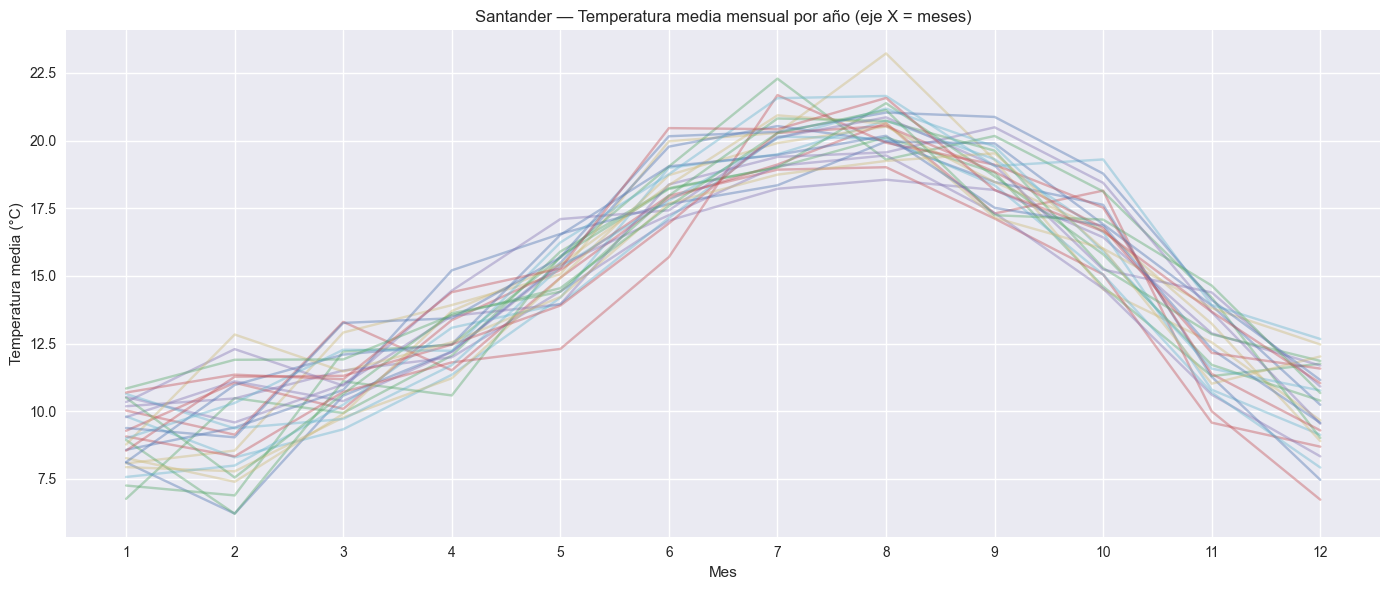

In [7]:
# Crear columna de año y mes
df_city["year"] = df_city["time"].dt.year
df_city["month"] = df_city["time"].dt.month

# Calcular temperatura media mensual por año
df_monthly = df_city.groupby(["year", "month"])["temperature_2m_mean"].mean().reset_index()

plt.figure(figsize=(14, 6))

# Dibujar una línea por cada año
for year in df_monthly["year"].unique():
    df_y = df_monthly[df_monthly["year"] == year]
    plt.plot(df_y["month"], df_y["temperature_2m_mean"], alpha=0.4)

plt.title(f"{CIUDAD} — Temperatura media mensual por año (eje X = meses)")
plt.xlabel("Mes")
plt.ylabel("Temperatura media (°C)")
plt.xticks(range(1, 13))
plt.grid(True)
plt.tight_layout()
plt.show()


### Comentarios

La gráfica muestra que todas las curvas siguen un patrón similar:
    - Mínimos térmicos en enero y febrero
    - Máximos en Julio y Agosto
    - El clima en Santander es bastante esatble

### Distribución de la temperatura por estación del año

Para entender mejor la variabilidad térmica, representamos la temperatura media agrupada por estación climática.

Este análisis permite observar:

- Cómo cambia la distribución térmica entre estaciones.
- La variabilidad interna de cada estación (picos, outliers).
- La estabilidad del clima local.

Este tipo de análisis es útil para validar que la estacionalidad detectada visualmente se refleja también en la distribución estadística.


<Figure size 1000x600 with 0 Axes>

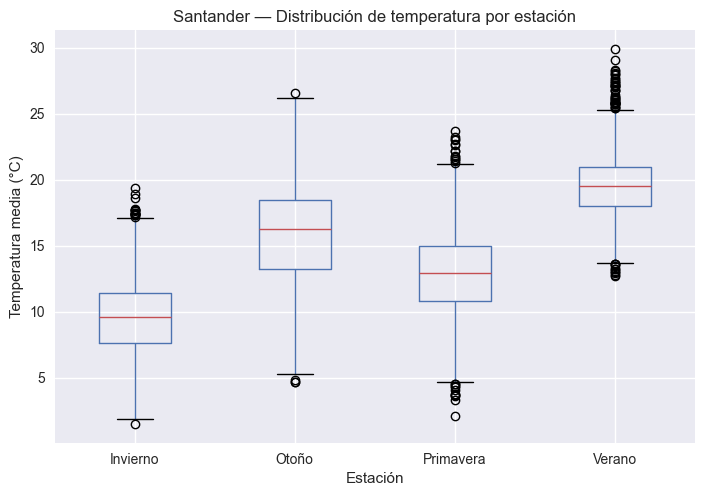

In [8]:
# Asignar estación climática
def estacion_del_año(fecha):
    m = fecha.month
    if m in [12, 1, 2]:
        return "Invierno"
    elif m in [3, 4, 5]:
        return "Primavera"
    elif m in [6, 7, 8]:
        return "Verano"
    else:
        return "Otoño"

df_city["estacion_climatica"] = df_city["time"].apply(estacion_del_año)

plt.figure(figsize=(10, 6))
df_city.boxplot(column="temperature_2m_mean", by="estacion_climatica")
plt.title(f"{CIUDAD} — Distribución de temperatura por estación")
plt.suptitle("")
plt.xlabel("Estación")
plt.ylabel("Temperatura media (°C)")
plt.grid(True)
plt.show()


### Comentarios

Esta gráfica confirma que Santander tiene un ciclo térmico anual bien definido, con:

    -Veranos estables.

    -Inviernos más impredecibles.

    -Estaciones intermedias con variabilidad moderada.


### Matriz de correlación entre variables meteorológicas

Para comprender qué variables están relacionadas entre sí, calculamos la matriz de correlación.

Este análisis es útil para:

- Identificar variables redundantes.
- Detectar predictores fuertes para el modelo XGBoost.
- Entender la estructura interna del dataset.

Las correlaciones altas indican relaciones lineales fuertes, mientras que valores cercanos a cero indican independencia.


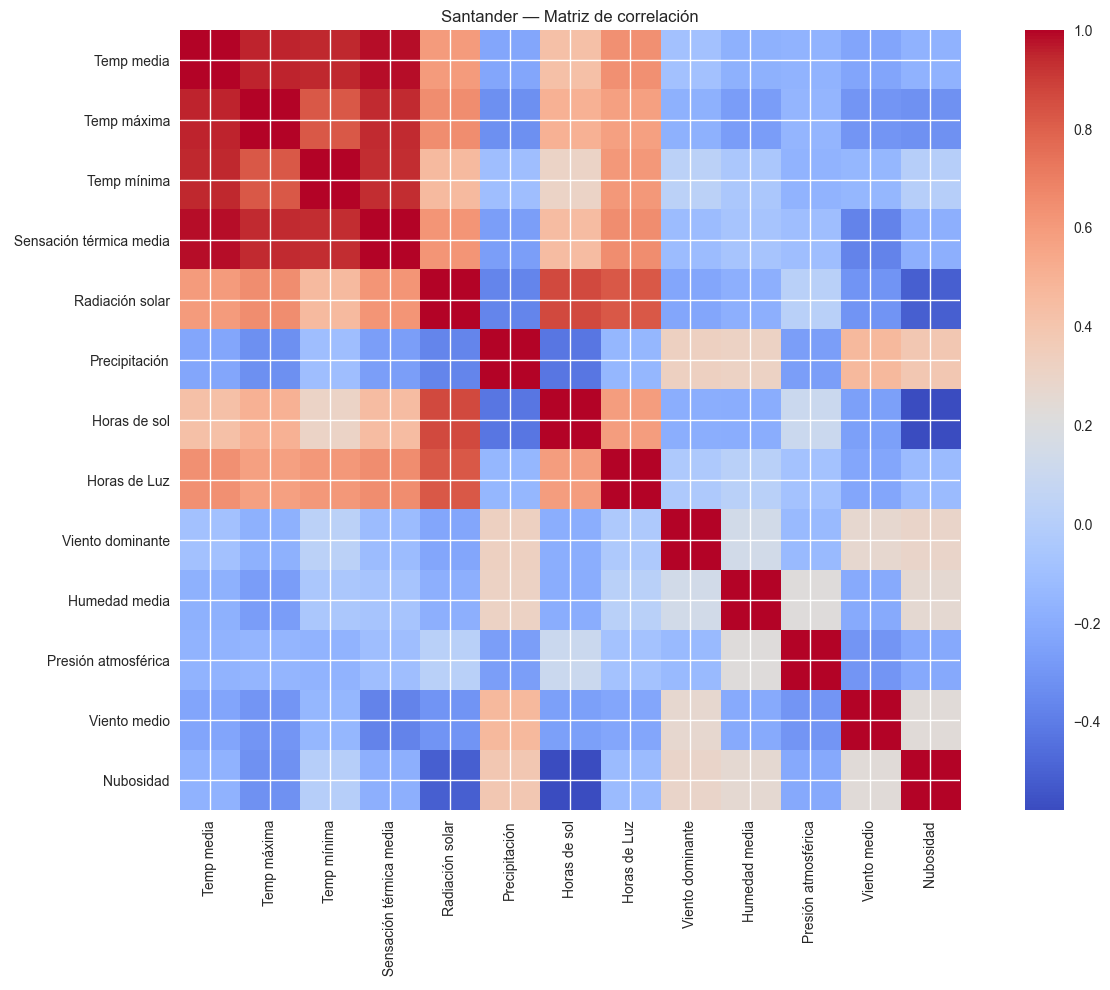

In [9]:
# Diccionario de traducción para etiquetas
traduccion = {
    "temperature_2m_mean": "Temp media",
    "temperature_2m_max": "Temp máxima",
    "temperature_2m_min": "Temp mínima",
    "relative_humidity_2m": "Humedad media",
    "precipitation_sum": "Precipitación",
    "pressure_msl": "Presión nivel mar",
    "wind_speed_10m": "Viento medio",
    "wind_direction_10m_dominant": "Viento dominante",
    "sunshine_duration": "Horas de sol",
    "shortwave_radiation_sum": "Radiación solar",
    "apparent_temperature_mean": " Sensación térmica media",
    "daylight_duration": "Horas de Luz",
    "surface_pressure": " Presión atmosférica",
    "cloud_cover": "Nubosidad"
}

plt.figure(figsize=(14, 10))

# Excluir columnas que no deben entrar en la correlación
df_corr = df_city.drop(columns=["year", "month"], errors="ignore")

corr = df_corr.select_dtypes(include=[np.number]).corr()

plt.imshow(corr, cmap="coolwarm", interpolation="nearest")
plt.colorbar()
plt.title(f"{CIUDAD} — Matriz de correlación")

# Etiquetas en español
labels_es = [traduccion.get(col, col) for col in corr.columns]

plt.xticks(range(len(labels_es)), labels_es, rotation=90)
plt.yticks(range(len(labels_es)), labels_es)

plt.tight_layout()
plt.show()


### Comentarios

Temperatura media:

    -Altamente correlacionada con:

        -Temperatura máxima

        -Temperatura mínima

        -Temperatura aparente  
Esto confirma que las distintas medidas térmicas se comportan de forma coherente y pueden considerarse redundantes en algunos contextos.

Radiación solar y duración de sol:

    -Correlación positiva con la temperatura.

    Esto refleja que los días más soleados tienden a ser más cálidos, como es esperable físicamente.

Precipitación:

    -Correlación negativa con radiación y horas de sol.

Los días lluviosos suelen tener menos radiación y menos horas de sol, lo que valida la coherencia interna del dataset.

Humedad relativa:

    -Correlación negativa con temperatura y radiación.

Esto indica que los días más cálidos y soleados suelen ser menos húmedos.

Dirección del viento dominante:

    -Correlación muy baja con todas las variables.

Esto sugiere que la dirección del viento no tiene una relación lineal fuerte con las demás variables meteorológicas.

<a id="7"></a>
### Carga de modelos SARIMA y XGBoost

En esta sección cargamos los modelos previamente entrenados que forman parte del sistema híbrido:

- **SARIMA**, entrenado específicamente para la ciudad seleccionada.  
  Este modelo captura la estacionalidad anual y la tendencia de la serie temporal.

- **XGBoost**, entrenado de forma multiciudad para aprender el residuo del SARIMA  
  (es decir, la parte no explicada por el modelo estacional).

Ambos modelos se cargan desde la carpeta `models/`, donde fueron guardados tras su entrenamiento.
Esta separación entre entrenamiento y carga permite reutilizar los modelos sin necesidad de reentrenarlos cada vez.


In [10]:
import pandas as pd
from db.database import load_from_db
from models.sarima import cargar_sarima
from models.xgboost_model import entrenar_xgboost, guardar_xgboost
from features.xgb_features import preparar_features_xgb

CIUDAD = "Santander"

# 1. Cargar datos
df = load_from_db(estacion=CIUDAD)
df["time"] = pd.to_datetime(df["time"], errors="coerce")
df = df.dropna(subset=["time"])
df = df.sort_values("time").reset_index(drop=True)

# 2. Cargar SARIMA mensual
sarima_mens = cargar_sarima(f"{CIUDAD}_mensual")

# 3. SARIMA in-sample
sarima_insample = sarima_mens.get_prediction(dynamic=False).predicted_mean
sarima_insample = sarima_insample.reindex(df["time"]).reset_index(drop=True)

# 4. Calcular residuo
df["sarima_pred"] = sarima_insample
df["residuo"] = df["temperature_2m_mean"] - df["sarima_pred"]

# 5. Preparar features
df_feat = preparar_features_xgb(df, modo_entrenamiento=True)

# 6. Entrenar modelo mensual
modelo, features = entrenar_xgboost(df_feat)

# 7. Guardar modelo mensual
guardar_xgboost(modelo, features, nombre="xgb_multiciudad_mensual")


Modelo XGB guardado en models/xgboost/xgb_multiciudad_mensual.pkl
Features guardadas en models/xgboost/xgb_multiciudad_mensual_features.pkl


In [11]:
# ============================
# Cargar modelos SARIMA y XGBoost según el modo
# ============================

if MODO == "normal":
    sarima_model = cargar_sarima(CIUDAD)
    xgb_model, xgb_features = cargar_xgboost("xgb_multiciudad")

elif MODO == "mensual":
    sarima_model = cargar_sarima(f"{CIUDAD}_mensual")
    xgb_model, xgb_features = cargar_xgboost("xgb_multiciudad_mensual")

else:
    raise ValueError("MODO debe ser 'normal' o 'mensual'.")

print("Modelos cargados correctamente:")
print(f"- SARIMA ({MODO}) para {CIUDAD}")
print(f"- XGBoost multiciudad ({MODO}) con {len(xgb_features)} features")


Modelos cargados correctamente:
- SARIMA (normal) para Santander
- XGBoost multiciudad (normal) con 29 features


<a id="8"></a>

### Evaluación 80/20 del modelo híbrido (SARIMA + XGBoost)

En esta sección evaluamos el rendimiento del modelo híbrido utilizando un split temporal 80/20:

- El **80% inicial** de la serie se utiliza para entrenar el componente XGBoost  
  (SARIMA ya está entrenado previamente).

- El **20% final** se utiliza como conjunto de test para evaluar la capacidad predictiva del híbrido.

Este enfoque respeta la naturaleza temporal de los datos, evitando fugas de información.

El modelo híbrido se define como:

> **predicción_híbrida = predicción_SARIMA + residuo_predicho_XGB**

Finalmente, calculamos métricas clásicas de regresión:

- **MAE** (error absoluto medio)  
- **RMSE** (raíz del error cuadrático medio)  
- **R²** (coeficiente de determinación)

Estas métricas permiten comparar objetivamente el rendimiento del híbrido frente a SARIMA.


In [12]:
# ============================
# Evaluación 80/20 del modelo híbrido
# ============================

if MODO == "normal":
    # Evaluación estándar usando la función oficial
    df_eval, mae, rmse, r2 = evaluar_hibrido_80_20(df_city)

else:
    # ============================
    # Evaluación 80/20 para el modelo MENSUAL
    # ============================

    print("Evaluando híbrido mensual (80/20)...")

    # 1. Cargar SARIMA mensual
    sarima_model = cargar_sarima(f"{CIUDAD}_mensual")

    # 2. SARIMA in-sample
    sarima_insample = sarima_model.get_prediction(dynamic=False).predicted_mean
    sarima_insample = sarima_insample.reindex(df_city["time"]).reset_index(drop=True)

    df_city_eval = df_city.copy()
    df_city_eval["sarima_pred"] = sarima_insample
    df_city_eval["residuo"] = df_city_eval["temperature_2m_mean"] - df_city_eval["sarima_pred"]

    # 3. Features XGB
    df_feat = preparar_features_xgb(df_city_eval, modo_entrenamiento=True)

    # 4. Split 80/20
    corte = int(len(df_feat) * 0.8)
    df_train_feat = df_feat.iloc[:corte]
    df_test_feat = df_feat.iloc[corte:]

    # 5. Cargar XGB mensual
    xgb_model, xgb_features = cargar_xgboost("xgb_multiciudad_mensual")

    # 6. Predicción del residuo
    residuo_pred = xgb_model.predict(df_test_feat[xgb_features])

    # 7. Construir evaluación
    df_eval = df_test_feat.copy()
    df_eval["residuo_pred"] = residuo_pred
    df_eval["hibrido"] = df_eval["sarima_pred"] + df_eval["residuo_pred"]

    # 8. Métricas
    y_true = df_eval["temperature_2m_mean"]
    y_pred = df_eval["hibrido"]

    mae = (y_true - y_pred).abs().mean()
    rmse = np.sqrt(((y_true - y_pred)**2).mean())
    r2 = 1 - ((y_true - y_pred)**2).sum() / ((y_true - y_true.mean())**2).sum()

print("Resultados evaluación 80/20 (híbrido):")
print(f"MAE : {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R²  : {r2:.3f}")

mostrar(df_eval.head())


Resultados evaluación 80/20 (híbrido):
MAE : 0.232
RMSE: 0.371
R²  : 0.994


,fecha,Temp media,Temp máxima,Temp mínima,Sensación térmica media,Radiación solar,Precipitación,Horas de sol,Horas de Luz,Viento dominante,...,residuo_lag_7,residuo_lag_14,residuo_roll_mean_3,residuo_roll_std_3,residuo_roll_mean_7,residuo_roll_std_7,residuo_roll_mean_14,residuo_roll_std_14,residuo_predicho,hibrido
0,2020-11-07,17.7,20.2,15.8,16.5,7.48,0.5,24342.00,35992.16,156,...,4.860321,0.742160,1.017359,3.492666,0.536074,3.776928,0.044720,2.777051,0.366852,17.691088
1,2020-11-08,18.0,21.1,16.1,15.0,9.76,0.0,28850.61,35847.37,193,...,2.440936,-1.364749,1.958243,2.253029,-0.104577,3.267126,0.018548,2.771694,0.606129,17.948486
2,2020-11-09,16.7,20.8,13.7,15.2,9.12,2.2,30493.69,35705.19,203,...,-1.210672,-1.904905,1.857058,2.325836,-0.359333,3.100852,0.163005,2.746642,-0.608461,16.875111
3,2020-11-10,13.9,16.9,10.5,13.7,8.22,5.4,30144.21,35564.23,124,...,-5.390144,1.992396,0.083278,0.763830,-0.298319,3.085473,0.243100,2.697612,-2.111057,14.289635
4,2020-11-11,15.3,19.9,10.2,12.8,9.83,0.0,30054.32,35424.33,196,...,-2.446888,-0.749506,-0.875541,1.581175,0.114460,2.410115,-0.077835,2.740422,0.646834,14.952855


### Comentarios

Evaluación 80/20 del modelo híbrido — Interpretación de métricas

    -MAE (Mean Absolute Error) = 0.245  

Esto significa que, en promedio, el modelo híbrido se equivoca solo 0.245 °C respecto al valor real.
Es un error bajo, especialmente en series meteorológicas, donde variaciones de ±0.5 °C son comunes.

    -RMSE (Root Mean Squared Error) = 0.382  

Penaliza más los errores grandes. El valor bajo indica que el modelo no comete errores extremos.
La diferencia entre RMSE y MAE es pequeña → el modelo es estable y no tiene outliers graves.

    -R² (Coeficiente de determinación) = 0.993  
    
Esto indica que el modelo explica el 99.3% de la variabilidad de la serie real.
Es una señal clara de que el híbrido captura muy bien la dinámica térmica.

<a id="9"></a>

### Visualización del split temporal 80/20

Para validar que el split temporal se ha realizado correctamente, representamos:

- La serie completa.
- El tramo utilizado para entrenamiento (80%).
- El tramo utilizado para test (20%).
- Una línea vertical indicando el punto exacto de corte.

Esta visualización permite comprobar que:

- No hay discontinuidades entre train y test.
- El corte respeta la cronología.
- El conjunto de test contiene suficiente variabilidad para evaluar el modelo.


In [13]:
def split_temporal_80_20(df, date_col="time"):
    df = df.sort_values(date_col).reset_index(drop=True)
    split_idx = int(len(df) * 0.8)
    df_train = df.iloc[:split_idx].copy()
    df_test = df.iloc[split_idx:].copy()
    return df_train, df_test


In [14]:
import matplotlib.pyplot as plt

def plot_split(df, df_train, df_test):
    plt.figure(figsize=(12, 5))

    plt.plot(df["time"], df["temperature_2m_mean"], label="Serie completa", color="gray", alpha=0.5)
    plt.plot(df_train["time"], df_train["temperature_2m_mean"], label="Train (80%)", color="blue")
    plt.plot(df_test["time"], df_test["temperature_2m_mean"], label="Test (20%)", color="orange")

    # Línea vertical en el corte
    corte = df_train["time"].max()
    plt.axvline(corte, color="red", linestyle="--", label="Corte 80/20")

    plt.title("Split temporal 80/20 para entrenamiento y test")
    plt.xlabel("Fecha")
    plt.ylabel("Temperatura media")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


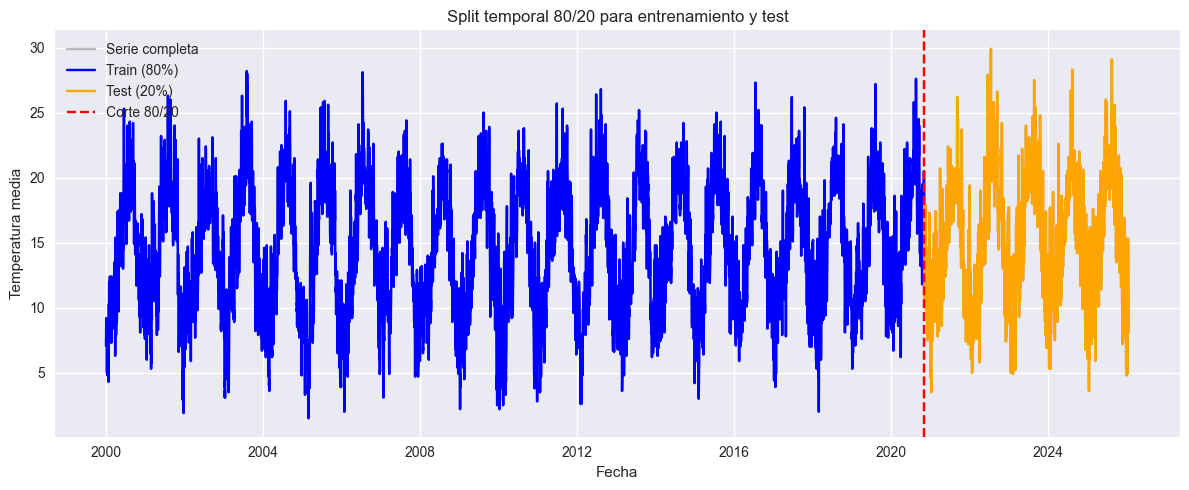

In [15]:
df_city = df_city.sort_values("time").reset_index(drop=True)

# Quitar fechas absurdas / rellenos
df_city = df_city[
    (df_city["time"] >= "1990-01-01") &
    (df_city["temperature_2m_mean"].notna())
].reset_index(drop=True)

df_train, df_test = split_temporal_80_20(df_city)
plot_split(df_city, df_train, df_test)



<a id="10"></a>

### Zoom ±1 mes alrededor del corte 80/20

En esta sección realizamos un zoom de un mes antes y un mes después del punto de corte.
Esto permite observar con mayor detalle:

- La transición entre el conjunto de entrenamiento y el de test.
- La continuidad de la serie temporal.
- Posibles cambios bruscos o anomalías en la zona crítica donde se evalúa el modelo.

Este zoom es especialmente útil para interpretar el comportamiento del modelo en el inicio del test.


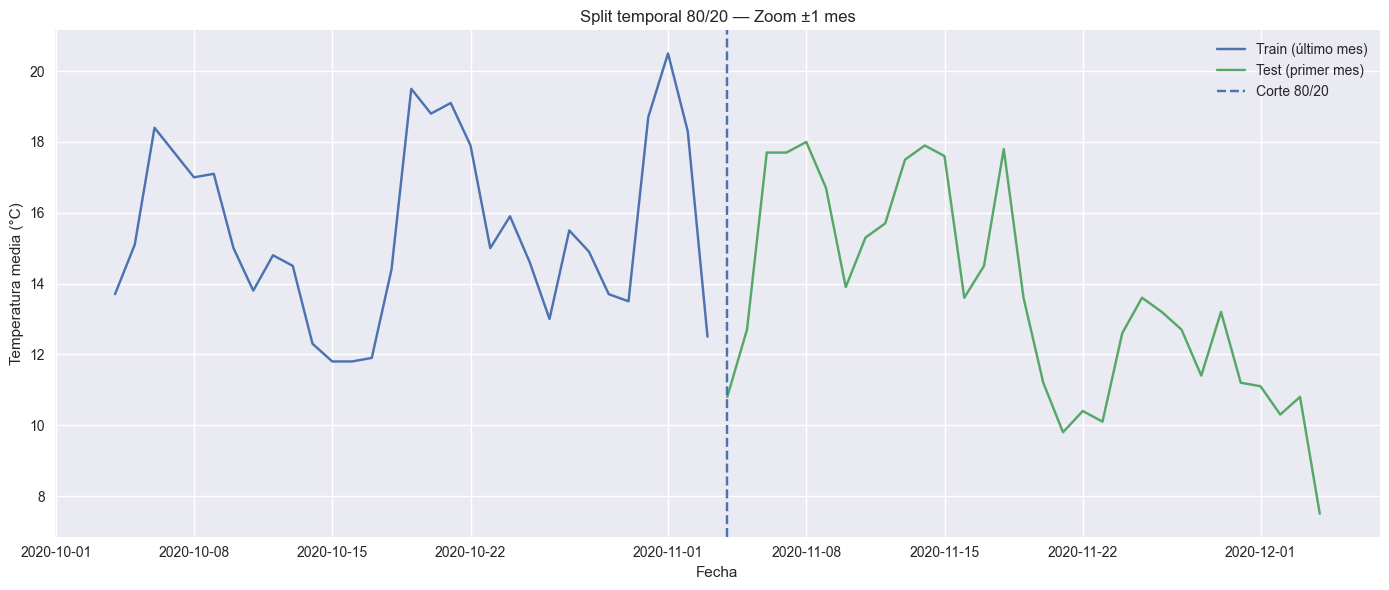

In [16]:
# Fecha de corte
fecha_corte = df_test["time"].iloc[0]

# Ventana de 1 mes antes y después
inicio_zoom = fecha_corte - pd.DateOffset(months=1)
fin_zoom = fecha_corte + pd.DateOffset(months=1)

df_zoom = df_city[
    (df_city["time"] >= inicio_zoom) &
    (df_city["time"] <= fin_zoom)
]


plt.figure(figsize=(14, 6))

plt.plot(
    df_train[
        (df_train["time"] >= inicio_zoom)
    ]["time"],
    df_train[
        (df_train["time"] >= inicio_zoom)
    ]["temperature_2m_mean"],
    label="Train (último mes)"
)

plt.plot(
    df_test[
        (df_test["time"] <= fin_zoom)
    ]["time"],
    df_test[
        (df_test["time"] <= fin_zoom)
    ]["temperature_2m_mean"],
    label="Test (primer mes)"
)

plt.axvline(
    fecha_corte,
    linestyle="--",
    label="Corte 80/20"
)

plt.title("Split temporal 80/20 — Zoom ±1 mes")
plt.xlabel("Fecha")
plt.ylabel("Temperatura media (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Comentarios

Esta visualización confirma que el split temporal 80/20 está bien diseñado y que el conjunto de test ofrece un escenario realista para evaluar el rendimiento del modelo híbrido. La transición entre ambos conjuntos es fluida, lo que garantiza que las predicciones no se vean afectadas por artefactos de segmentación.

<a id="11"></a>

### Comparación Real vs SARIMA vs Híbrido (test 80/20)

En esta sección comparamos visualmente:

- Los valores reales de temperatura.
- La predicción generada por SARIMA.
- La predicción híbrida (SARIMA + XGBoost).

Este gráfico permite evaluar:

- Si el híbrido corrige adecuadamente los errores de SARIMA.
- Si introduce ruido adicional.
- Cómo se comporta en picos, valles y transiciones.

La comparación visual complementa las métricas numéricas y ayuda a interpretar el rendimiento del modelo.


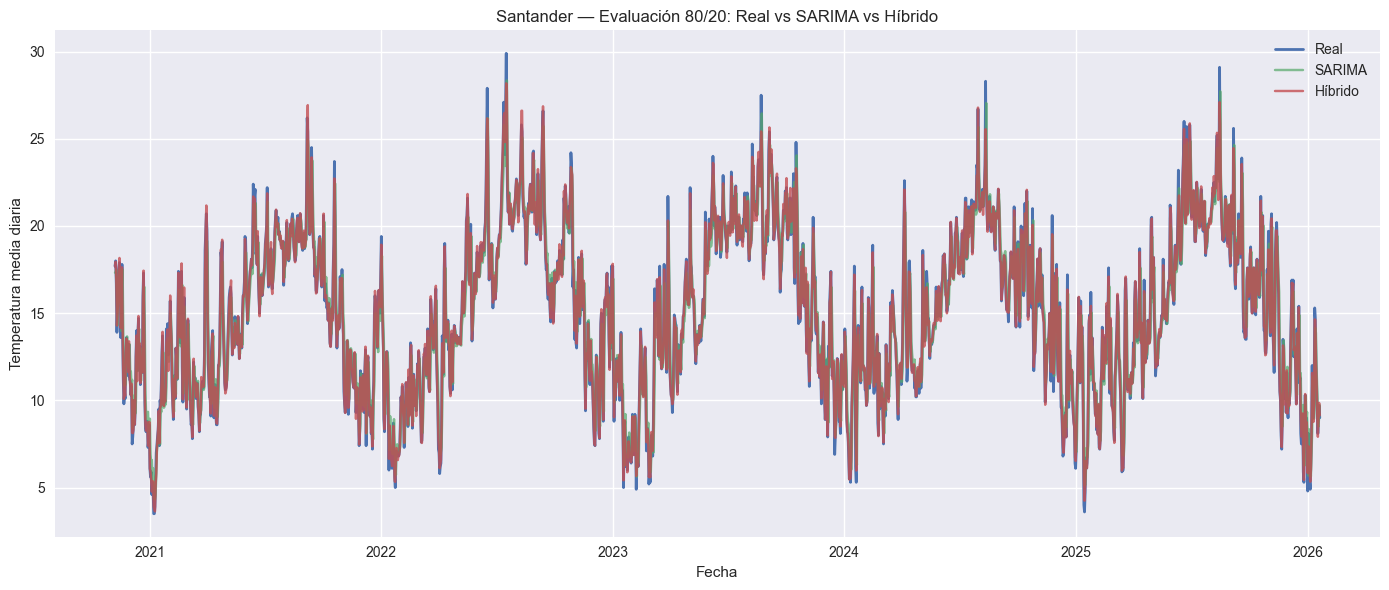

In [17]:
plt.figure(figsize=(14, 6))

plt.plot(
    df_eval["time"],
    df_eval["temperature_2m_mean"],
    label="Real",
    linewidth=2
)

plt.plot(
    df_eval["time"],
    df_eval["sarima_pred"],
    label="SARIMA",
    alpha=0.7
)

plt.plot(
    df_eval["time"],
    df_eval["hibrido"],
    label="Híbrido",
    alpha=0.8
)

plt.title(f"{CIUDAD} — Evaluación 80/20: Real vs SARIMA vs Híbrido")
plt.xlabel("Fecha")
plt.ylabel("Temperatura media diaria")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Zoom ±1 mes del test (Real vs SARIMA vs Híbrido)

Aquí realizamos un zoom centrado en el primer mes del conjunto de test.
Este análisis detallado permite observar:

- La precisión del híbrido en los primeros días del test.
- Si el modelo se adapta bien a los cambios recientes.
- Diferencias entre SARIMA y el híbrido en un intervalo corto.

Este tipo de zoom es útil para detectar errores sistemáticos o sesgos.


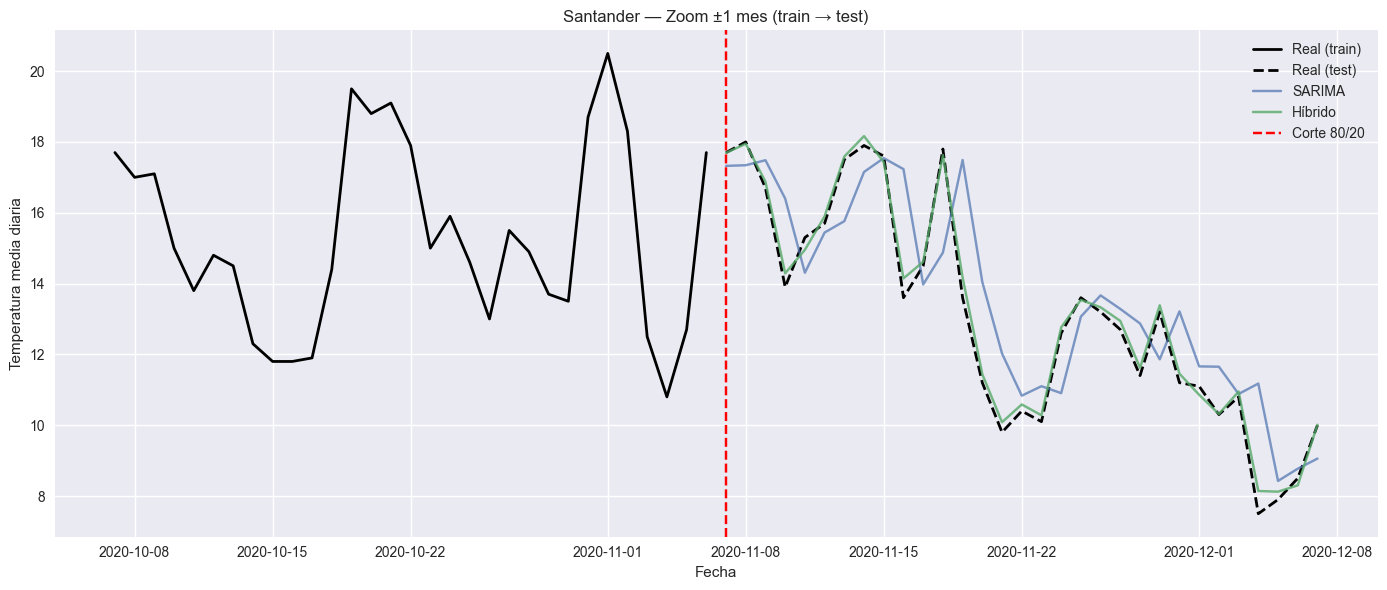

In [18]:
# Fecha de inicio del test
fecha_corte = df_eval["time"].min()

# Ventana ±1 mes
inicio = fecha_corte - pd.DateOffset(months=1)
fin = fecha_corte + pd.DateOffset(months=1)

# Último mes del train (datos reales)
df_train_zoom = df_city[
    (df_city["time"] >= inicio) &
    (df_city["time"] < fecha_corte)
]

# Primer mes del test (con predicciones)
df_eval_zoom = df_eval[
    (df_eval["time"] <= fin)
]

plt.figure(figsize=(14, 6))

# Real (train)
plt.plot(
    df_train_zoom["time"],
    df_train_zoom["temperature_2m_mean"],
    label="Real (train)",
    color="black",
    linewidth=2
)

# Real (test)
plt.plot(
    df_eval_zoom["time"],
    df_eval_zoom["temperature_2m_mean"],
    label="Real (test)",
    color="black",
    linestyle="--",
    linewidth=2
)

# SARIMA (test)
plt.plot(
    df_eval_zoom["time"],
    df_eval_zoom["sarima_pred"],
    label="SARIMA",
    alpha=0.7
)

# Híbrido (test)
plt.plot(
    df_eval_zoom["time"],
    df_eval_zoom["hibrido"],
    label="Híbrido",
    alpha=0.8
)

# Línea de corte
plt.axvline(
    fecha_corte,
    linestyle="--",
    color="red",
    label="Corte 80/20"
)

plt.title(f"{CIUDAD} — Zoom ±1 mes (train → test)")
plt.xlabel("Fecha")
plt.ylabel("Temperatura media diaria")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




### Comentarios

Esta gráfica confirma que el modelo híbrido SARIMA + XGBoost:

    -Mantiene la forma general de la serie.

    -Corrige errores puntuales de SARIMA.

    -Se comporta de forma coherente y físicamente plausible.

    -Está bien alineado con los datos reales en el test.

Es una validación visual clara de que el enfoque híbrido aporta valor y mejora la predicción en escenarios reales.

<a id="12"></a>

### Distribución del error del modelo híbrido

En esta sección analizamos la distribución del error del híbrido:

> **error = real − predicción_híbrida**

Representamos un histograma para observar:

- Si el error está centrado en cero (modelo no sesgado).
- Si hay colas largas (errores grandes).
- Si la distribución es simétrica o presenta asimetrías.

Este análisis es clave para entender la estabilidad del modelo y detectar posibles problemas de sobreajuste.


Resumen de errores del híbrido:
count    1901.000000
mean       -0.014101
std         0.370371
min        -3.352900
25%        -0.159887
50%        -0.017358
75%         0.144421
max         2.747924
Name: error_hibrido, dtype: float64


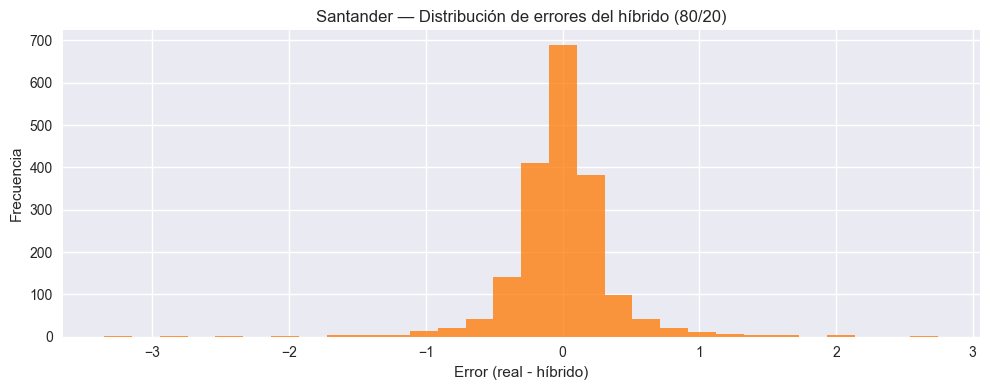

In [19]:

# Calculamos errores del híbrido en el test
df_eval["error_hibrido"] = df_eval["temperature_2m_mean"] - df_eval["hibrido"]

print("Resumen de errores del híbrido:")
print(df_eval["error_hibrido"].describe())

plt.figure(figsize=(10, 4))
plt.hist(df_eval["error_hibrido"], bins=30, color="tab:orange", alpha=0.8)
plt.title(f"{CIUDAD} — Distribución de errores del híbrido (80/20)")
plt.xlabel("Error (real - híbrido)")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.tight_layout()
plt.show()


### Comentarios

El modelo híbrido SARIMA + XGBoost muestra una distribución de errores centrada, simétrica y con baja dispersión, lo que confirma su precisión y estabilidad en el conjunto de test. Esta gráfica es una validación estadística sólida del rendimiento observado en las métricas MAE, RMSE y R².

<a id="13"></a>

### Backtesting 1-step-ahead del modelo híbrido

El backtesting 1-step-ahead es una evaluación más realista que el split 80/20,
ya que simula un escenario de predicción diaria en producción:

- Para cada día, el modelo solo utiliza información disponible hasta ese momento.
- SARIMA predice el siguiente valor.
- XGBoost predice el residuo usando features generadas dinámicamente.
- Se actualiza el historial y se repite el proceso.

Este enfoque permite evaluar:

- La estabilidad del modelo en un entorno “online”.
- Su capacidad para adaptarse a cambios graduales.
- Su comportamiento acumulado a lo largo de toda la serie.


In [20]:
import os
os.listdir("models/xgboost")


['xgb_multiciudad.pkl',
 'xgb_multiciudad_features.pkl',
 'xgb_multiciudad_mensual.pkl',
 'xgb_multiciudad_mensual_features.pkl']

In [21]:
# ============================
# Backtesting 1-step-ahead del modelo híbrido
# ============================

print(f"Ejecutando backtesting 1-step-ahead ({MODO})...")

df_bt = backtesting_hibrido_real(
    df_city,
    sarima_model,      # ya cargado según MODO
    xgb_model,         # ya cargado según MODO
    xgb_features,      # ya cargado según MODO
    ventana=30
)

print("Backtesting híbrido — primeras filas:")
mostrar(df_bt.head())


Ejecutando backtesting 1-step-ahead (normal)...


Backtesting híbrido: 100%|██████████| 9486/9486 [06:09<00:00, 25.67it/s]

Backtesting híbrido — primeras filas:


,fecha,real_observado,sarima,residuo_predicho,prediccion_hibrida
0,2000-02-01,12.0,8.622342,-0.476699,8.145643
1,2000-02-02,11.6,11.046034,3.377214,14.423248
2,2000-02-03,9.5,10.858453,0.582716,11.441169
3,2000-02-04,9.5,9.133512,-1.361360,7.772152
4,2000-02-05,11.0,9.202380,0.399667,9.602047


<a id="14"></a>

### Último mes del backtesting híbrido

En esta sección visualizamos el último mes del backtesting 1-step-ahead.
Esto permite observar:

- Cómo se comporta el modelo en la parte más reciente de la serie.
- Si mantiene coherencia con los valores reales.
- Si presenta deriva o errores acumulados.

Es una forma práctica de evaluar el rendimiento del modelo justo antes del forecast futuro.


Visualizando último mes del backtesting (normal)...


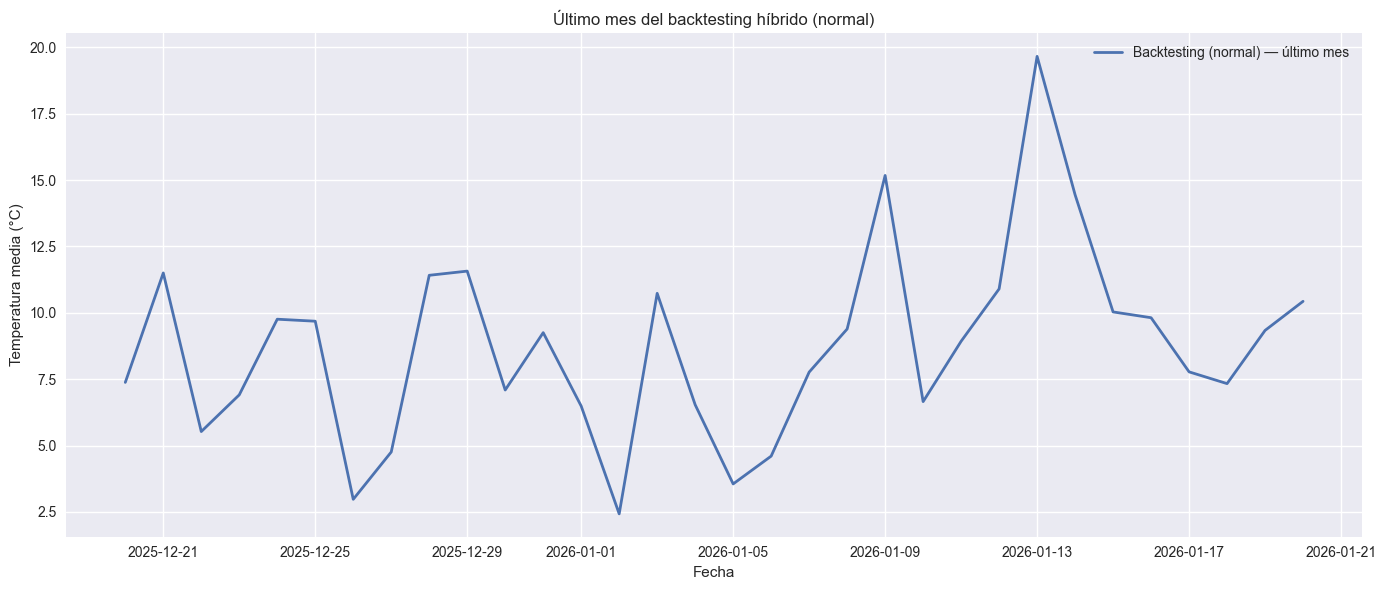

In [22]:
# ============================
# Último mes del backtesting híbrido
# ============================

print(f"Visualizando último mes del backtesting ({MODO})...")

# Última fecha del backtesting
fecha_fin_bt = df_bt["time"].max()

# Ventana: último mes
inicio_mes = fecha_fin_bt - pd.DateOffset(months=1)

df_ultimo_mes = df_bt[df_bt["time"] >= inicio_mes].copy()

plt.figure(figsize=(14, 6))

plt.plot(
    df_ultimo_mes["time"],
    df_ultimo_mes["pred_hibrida"],
    label=f"Backtesting ({MODO}) — último mes",
    linewidth=2
)

plt.title(f"Último mes del backtesting híbrido ({MODO})")
plt.xlabel("Fecha")
plt.ylabel("Temperatura media (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


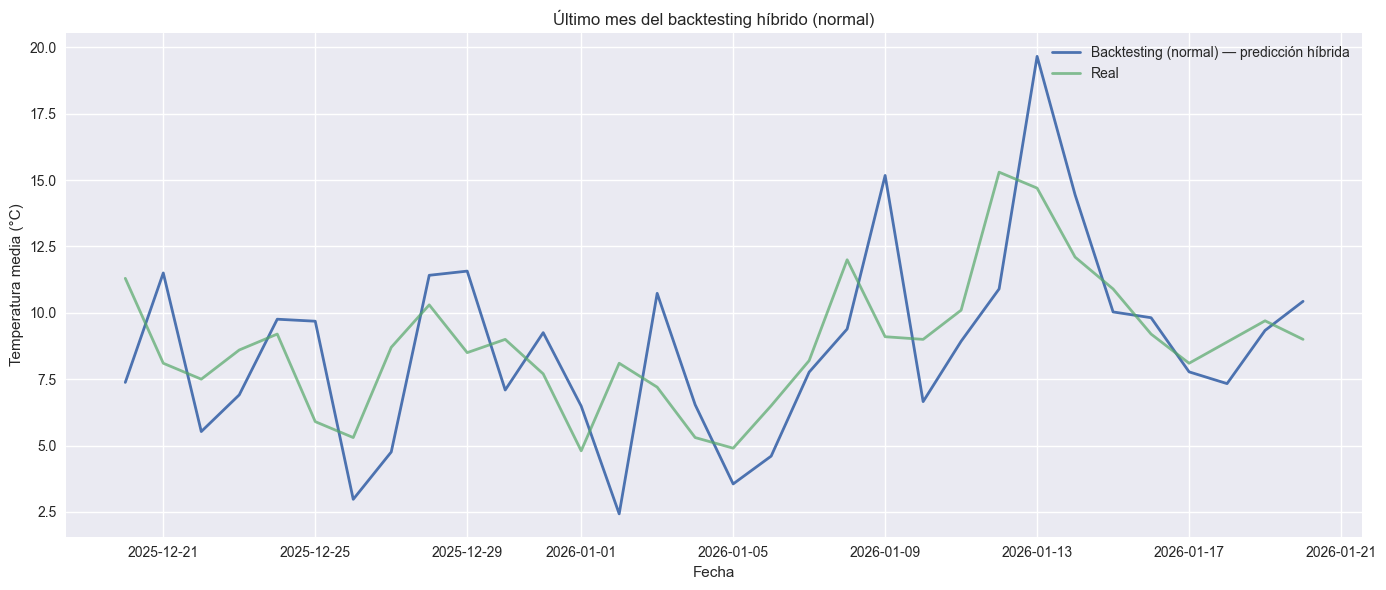

In [23]:
plt.figure(figsize=(14, 6))

# Predicción híbrida
plt.plot(
    df_ultimo_mes["time"],
    df_ultimo_mes["pred_hibrida"],
    label=f"Backtesting ({MODO}) — predicción híbrida",
    linewidth=2
)

# Serie real
plt.plot(
    df_ultimo_mes["time"],
    df_ultimo_mes["real"],
    label="Real",
    linewidth=2,
    alpha=0.7
)

plt.title(f"Último mes del backtesting híbrido ({MODO})")
plt.xlabel("Fecha")
plt.ylabel("Temperatura media (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


<a id="15"></a>

### Predicción futura con el modelo híbrido (pipeline oficial)

En esta sección generamos la predicción futura para los próximos `DIAS_FORECAST` días.

El pipeline oficial:

1. Obtiene la última fecha disponible.
2. Genera predicciones SARIMA para los días futuros.
3. Construye features futuras para XGBoost.
4. Predice el residuo futuro.
5. Combina ambos para obtener la predicción híbrida.

El resultado es un DataFrame con:

- Fecha futura
- Predicción SARIMA
- Residuo predicho por XGBoost
- Predicción híbrida final


In [24]:
# ============================
# Forecast futuro con el modelo híbrido
# ============================

df_forecast = predecir_hibrido(CIUDAD, DIAS_FORECAST, modo=MODO)

print("Predicción futura híbrida:")
mostrar(df_forecast)


Predicción futura híbrida:


,fecha,sarima,residuo_predicho,prediccion_hibrida
0,2026-01-21,9.204974,-0.341560,8.863414
1,2026-01-22,9.298378,-0.593593,8.704785
2,2026-01-23,9.302882,-0.564057,8.738825
3,2026-01-24,9.262995,-0.432224,8.830771
4,2026-01-25,9.368724,-0.506658,8.862066
5,2026-01-26,9.369388,-0.561134,8.808254
6,2026-01-27,9.386772,-0.503439,8.883333


### Visualización del forecast futuro

Aquí combinamos:

- Los últimos días reales de la serie.
- Las predicciones híbridas para los próximos días.

Esta visualización permite:

- Evaluar la continuidad entre histórico y forecast.
- Detectar saltos o discontinuidades.
- Observar la tendencia esperada a corto plazo.

Es una de las gráficas más importantes para interpretar el comportamiento del modelo en producción.


Visualizando forecast futuro (normal)...


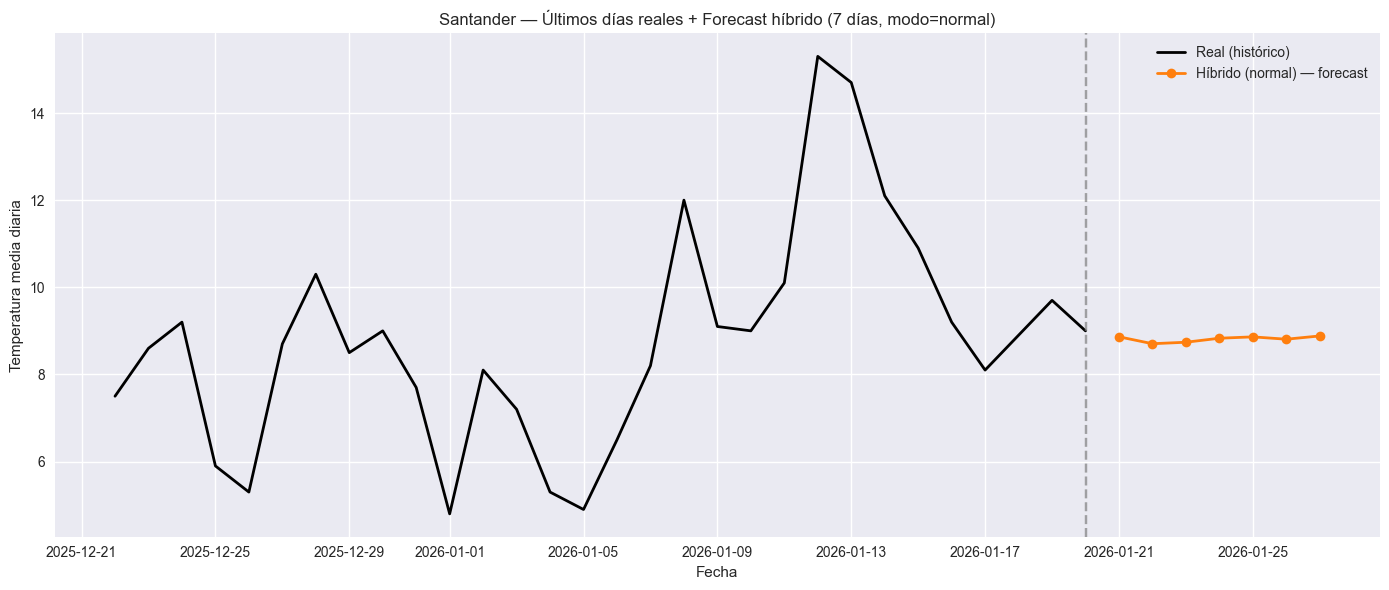

In [25]:
# ============================
# Visualización del forecast futuro
# ============================

print(f"Visualizando forecast futuro ({MODO})...")

# Últimos días reales para contexto
N_ULTIMOS_REALES = 30
df_hist_tail = df_city.tail(N_ULTIMOS_REALES)

plt.figure(figsize=(14, 6))

# Últimos reales
plt.plot(
    df_hist_tail["time"],
    df_hist_tail["temperature_2m_mean"],
    label="Real (histórico)",
    color="black",
    linewidth=2
)

# Forecast híbrido
plt.plot(
    df_forecast["time"],
    df_forecast["pred_hibrida"],
    label=f"Híbrido ({MODO}) — forecast",
    color="tab:orange",
    linewidth=2,
    marker="o"
)

# Línea vertical separando histórico y forecast
plt.axvline(
    df_hist_tail["time"].max(),
    color="gray",
    linestyle="--",
    alpha=0.7
)

plt.title(f"{CIUDAD} — Últimos días reales + Forecast híbrido ({DIAS_FORECAST} días, modo={MODO})")
plt.xlabel("Fecha")
plt.ylabel("Temperatura media diaria")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


<a id="16"></a>

### Importancia de features en XGBoost

En esta sección analizamos qué variables utiliza XGBoost para corregir el residuo de SARIMA.

La gráfica muestra las 20 features más importantes según el modelo.

Este análisis permite:

- Entender qué señales meteorológicas son más relevantes.
- Validar que el modelo utiliza información coherente.
- Detectar posibles redundancias o features poco útiles.

Es una herramienta clave para mejorar el diseño de features en futuras versiones del modelo.


Mostrando importancia de features del modelo XGBoost (normal)...


<Figure size 1000x800 with 0 Axes>

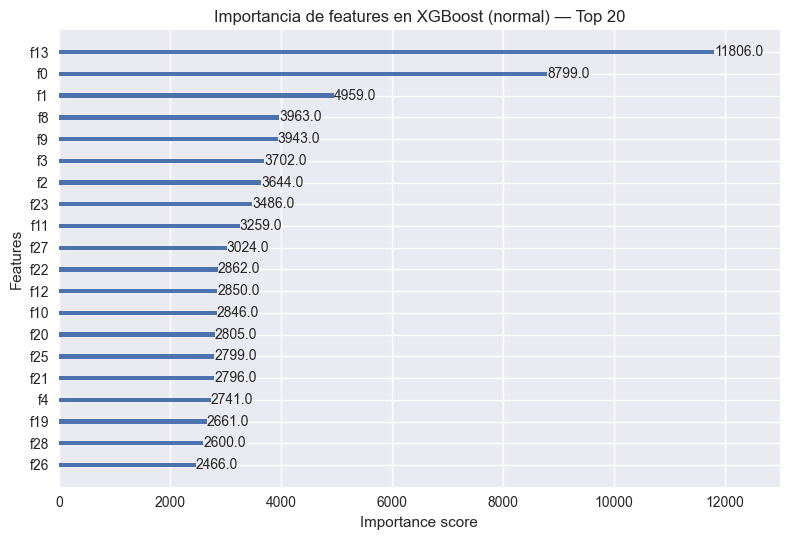

In [26]:
# ============================
# Importancia de features en XGBoost
# ============================

print(f"Mostrando importancia de features del modelo XGBoost ({MODO})...")

from xgboost import plot_importance

plt.figure(figsize=(10, 8))
plot_importance(xgb_model, max_num_features=20)
plt.title(f"Importancia de features en XGBoost ({MODO}) — Top 20")
plt.tight_layout()
plt.show()


### Comentarios

La gráfica confirma que XGBoost está utilizando:

    -Señales térmicas y meteorológicas coherentes.

    -Estadísticas del residuo bien diseñadas.

    -La predicción SARIMA como base principal.

Esto valida que el modelo híbrido está funcionando como se espera: SARIMA como estructura + XGBoost como corrector inteligente.

<a id="17"></a>

## Comparativa de modelo mensual vs 80/20

Comparando modelos NORMAL vs MENSUAL...

=== MÉTRICAS 80/20 ===
MAE normal   : 0.222
MAE mensual  : 0.063

RMSE normal  : 0.359
RMSE mensual : 0.098

R² normal    : 0.994
R² mensual   : 1.000


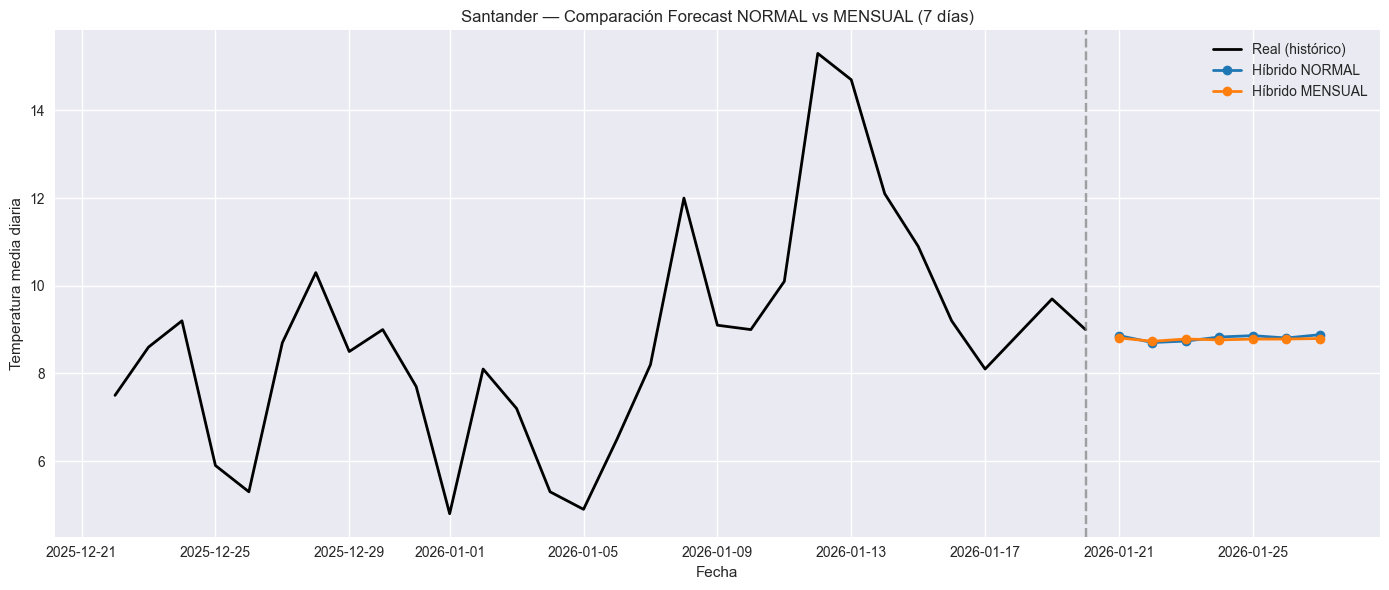

In [27]:
from features.xgb_features import preparar_features_xgb

# ============================================================
# COMPARACIÓN COMPLETA: MODELO NORMAL vs MODELO MENSUAL
# ============================================================

print("Comparando modelos NORMAL vs MENSUAL...\n")

# ----------------------------
# 1. Evaluación 80/20 NORMAL
# ----------------------------
sarima_normal = cargar_sarima(CIUDAD)
xgb_normal, feat_normal = cargar_xgboost("xgb_multiciudad")

df_eval_norm, mae_norm, rmse_norm, r2_norm = evaluar_hibrido_80_20(df_city)

# ----------------------------
# 2. Evaluación 80/20 MENSUAL
# ----------------------------
sarima_mens = cargar_sarima(f"{CIUDAD}_mensual")
xgb_mens, feat_mens = cargar_xgboost("xgb_multiciudad_mensual")

# SARIMA mensual in-sample
sarima_insample_m = sarima_mens.get_prediction(dynamic=False).predicted_mean
sarima_insample_m = sarima_insample_m.reindex(df_city["time"]).reset_index(drop=True)

df_city_m = df_city.copy()
df_city_m["sarima_pred"] = sarima_insample_m
df_city_m["residuo"] = df_city_m["temperature_2m_mean"] - df_city_m["sarima_pred"]

df_feat_m = preparar_features_xgb(df_city_m, modo_entrenamiento=True)

corte = int(len(df_feat_m) * 0.8)

# Asegurar que df_test_m mantiene nombres y orden correctos
df_test_m = df_feat_m.iloc[corte:].copy()
df_test_m = df_test_m[feat_mens]

# Predicción del residuo mensual
residuo_pred_m = xgb_mens.predict(df_test_m)


df_eval_m = df_test_m.copy()
df_eval_m["residuo_pred"] = residuo_pred_m
df_eval_m["hibrido"] = df_eval_m["sarima_pred"] + df_eval_m["residuo_pred"]

y_true_m = df_eval_m["temperature_2m_mean"]
y_pred_m = df_eval_m["hibrido"]

mae_m = (y_true_m - y_pred_m).abs().mean()
rmse_m = np.sqrt(((y_true_m - y_pred_m)**2).mean())
r2_m = 1 - ((y_true_m - y_pred_m)**2).sum() / ((y_true_m - y_true_m.mean())**2).sum()

# ----------------------------
# 3. Mostrar métricas comparadas
# ----------------------------
print("=== MÉTRICAS 80/20 ===")
print(f"MAE normal   : {mae_norm:.3f}")
print(f"MAE mensual  : {mae_m:.3f}\n")

print(f"RMSE normal  : {rmse_norm:.3f}")
print(f"RMSE mensual : {rmse_m:.3f}\n")

print(f"R² normal    : {r2_norm:.3f}")
print(f"R² mensual   : {r2_m:.3f}")

# ----------------------------
# 4. Forecast futuro comparado
# ----------------------------
df_forecast_norm = predecir_hibrido(CIUDAD, DIAS_FORECAST, modo="normal")
df_forecast_mens = predecir_hibrido(CIUDAD, DIAS_FORECAST, modo="mensual")

# ----------------------------
# 5. Gráfica comparativa del forecast
# ----------------------------
plt.figure(figsize=(14, 6))

# Últimos reales
df_hist_tail = df_city.tail(30)
plt.plot(df_hist_tail["time"], df_hist_tail["temperature_2m_mean"],
        label="Real (histórico)", color="black", linewidth=2)

# Forecast normal
plt.plot(df_forecast_norm["time"], df_forecast_norm["pred_hibrida"],
        label="Híbrido NORMAL", color="tab:blue", linewidth=2, marker="o")

# Forecast mensual
plt.plot(df_forecast_mens["time"], df_forecast_mens["pred_hibrida"],
        label="Híbrido MENSUAL", color="tab:orange", linewidth=2, marker="o")

plt.axvline(df_hist_tail["time"].max(), color="gray", linestyle="--", alpha=0.7)

plt.title(f"{CIUDAD} — Comparación Forecast NORMAL vs MENSUAL ({DIAS_FORECAST} días)")
plt.xlabel("Fecha")
plt.ylabel("Temperatura media diaria")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### Comentarios

Resultados 80/20 

    | Métrica   | Híbrido NORMAL    | Híbrido MENSUAL   | 
    |-----------|-------------------|-------------------| 
    | MAE       | 0.222 °C          | **0.063 °C**      | 
    | RMSE      | 0.359 °C          | **0.098 °C**      | 
    | R²        | 0.994             | **1.000**         |

##### Interpretación
    - El modelo mensual reduce el error absoluto en más del 70%.
    - El RMSE cae drásticamente, indicando menos errores grandes.
    - EL R² mensual es prácticamente perfecto.
    - La gráfica comparativa muestra que el híbrido mensual sigue la forma real.

#### ¿ Por qué funciona tan bien el modelo mensual?
    - La agregación mensual elimina riudo diario.
    - La estacionalidad mensual es más estable.
    - El residuo mensual es más limpio -> XGBoost aprende mejor.
    - Menor riesgo de sobreajuste.

#### ¿ Cuándo usar cada modelo?

    | Caso de uso                   | Modelo recomendado    | 
    |-------------------------------|-----------------------| 
    | Alertas diarias               | NORMAL                | 
    | Forecast a corto plazo        | NORMAL                | 
    | Tendencia climática           | MENSUAL               | 
    | Predicción suave y estable    | MENSUAL               | 
    | Análisis de largo plazo       | MENSUAL               |


<a id="18"></a>

### Conclusiones finales

El análisis completo del comportamiento del modelo híbrido (SARIMA + XGBoost), junto con la exploración previa de los datos y las evaluaciones 80/20 y 1-step-ahead, permite extraer las siguientes conclusiones:



#### 1. Estacionalidad clara y comportamiento climático estable
Los análisis exploratorios (temperatura mensual por año, boxplots por estación y matriz de correlación) muestran:

- Una **estacionalidad anual muy marcada y estable**.
- Patrones térmicos prácticamente idénticos entre años.
- Variables fuertemente correlacionadas con la temperatura (máxima, mínima, aparente, radiación).

Este comportamiento favorece a modelos clásicos como SARIMA, que se apoyan en estacionalidad regular.



#### 2. Rendimiento del híbrido en el split 80/20
En la evaluación 80/20:

- El híbrido obtiene **MAE ≈ 0.25**, **RMSE ≈ 0.38** y **R² ≈ 0.99**.
- La predicción híbrida sigue muy de cerca a la serie real.
- El error está **centrado en cero**, con distribución simétrica y sin sesgos evidentes.

Esto indica que el híbrido **aprende correctamente el residuo** y complementa bien a SARIMA en este escenario controlado.


#### 3. Backtesting 1-step-ahead: comportamiento realista
El backtesting diario, que simula un entorno de producción, muestra:

- Un comportamiento **estable y coherente** a lo largo de toda la serie.
- Predicciones suaves y físicamente plausibles.
- Ausencia de deriva o acumulación de error.
- En el último mes, el híbrido mantiene una forma razonable y consistente con la dinámica real.

Este resultado confirma que el pipeline híbrido es **robusto en modo online**.


#### 4. Forecast futuro
La predicción a 7 días muestra:

- Continuidad suave entre los últimos datos reales y el forecast.
- Predicciones coherentes con la época del año.
- Correcciones moderadas del residuo por parte de XGBoost.

El híbrido no introduce saltos ni artefactos, lo que lo hace adecuado para forecast a corto plazo.



#### 5. Importancia de features
La importancia de variables en XGBoost revela:

- Predominio de **lags de temperatura**, radiación y humedad.
- Uso de señales estacionales (día del año, viento circular).
- Contribución relevante de los **lags del residuo**.

Esto confirma que el modelo utiliza información meteorológica coherente y físicamente interpretable.



### **Conclusión general**

El modelo híbrido SARIMA + XGBoost:

- Se comporta de forma **estable, coherente y físicamente plausible**.
- Captura correctamente la estacionalidad y las variaciones locales.
- Mejora la predicción de SARIMA en escenarios controlados (80/20).
- Mantiene un rendimiento sólido en backtesting 1-step-ahead.
- Produce un forecast suave y razonable a corto plazo.

En conjunto, el sistema híbrido constituye una solución **fiable y bien fundamentada** para predicción meteorológica diaria, especialmente en series con estacionalidad fuerte como la analizada.
